In [149]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [51]:
def load_dataset(dataset_path="dataset", image_size=224, batch_size=32, split_ratio=0.8):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

    full_dataset = ImageFolder(root=dataset_path, transform=transform)
    class_names = full_dataset.classes

    train_size = int(split_ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, class_names

In [55]:
train_loader, test_loader, class_names = load_dataset()
print("Classes:", class_names)

Classes: ['cats', 'dogs', 'horses']


In [61]:
def get_resnet_stages(weights_path=None):
    if weights_path is None:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18()
        state_dict = torch.load(weights_path, weights_only=True)
        model.load_state_dict(state_dict)

    model.eval()

    stages = {
        "initial": nn.Sequential(  # low-level features
            model.conv1,
            model.bn1,
            model.relu
        ),
        "mid": nn.Sequential(      # mid-level features
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2
        ),
        "high": nn.Sequential(     # high-level features
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
            model.avgpool
        )
    }
    return stages

In [69]:
def extract_features(model_stage, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model_stage = model_stage.to(device)
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            output = model_stage(images)
            output = output.view(output.size(0), -1)  

            features.append(output.cpu())  
            labels.append(targets)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features.numpy(), labels.numpy()

In [105]:
stages = get_resnet_stages("resnet18-f37072fd.pth")
high_features, high_labels = extract_features(stages['high'], train_loader)
print(initial_features.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_24456\131306688.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Using device: cuda
(484, 512)


In [97]:
def compare_feature_visualizations(features, labels, class_names):
    methods = {
        'PCA': PCA(n_components=2),
        't-SNE': TSNE(n_components=2, random_state=42, perplexity=30)
    }

    reduced = {}
    for name, reducer in methods.items():
        reduced[name] = reducer.fit_transform(features)

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for ax, (method_name, data) in zip(axes, reduced.items()):
        for class_idx in np.unique(labels):
            idxs = np.where(labels == class_idx)
            ax.scatter(data[idxs, 0], data[idxs, 1],
                       label=class_names[class_idx], alpha=0.7)
        ax.set_title(f"{method_name} Projection")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

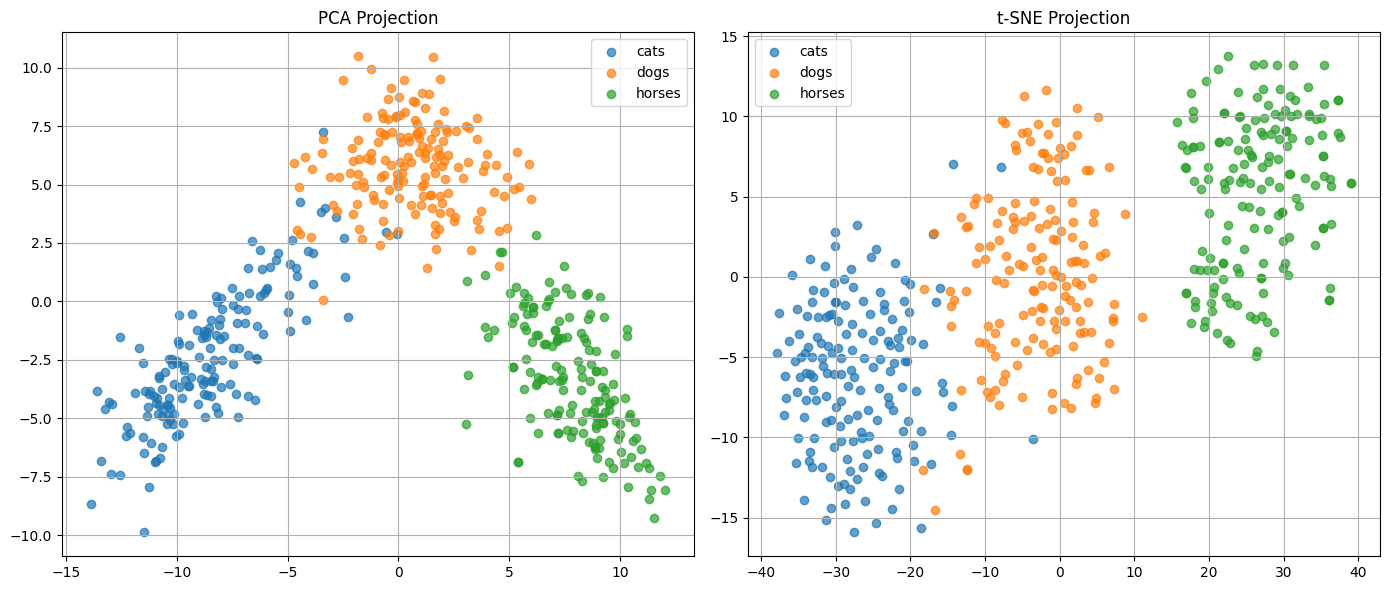

In [107]:
compare_feature_visualizations(high_features, high_labels, class_names)

In [101]:
stages = get_resnet_stages("resnet18-f37072fd.pth")
mid_features, mid_labels = extract_features(stages['mid'], train_loader)
print(initial_features.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_24456\131306688.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Using device: cuda
(484, 512)


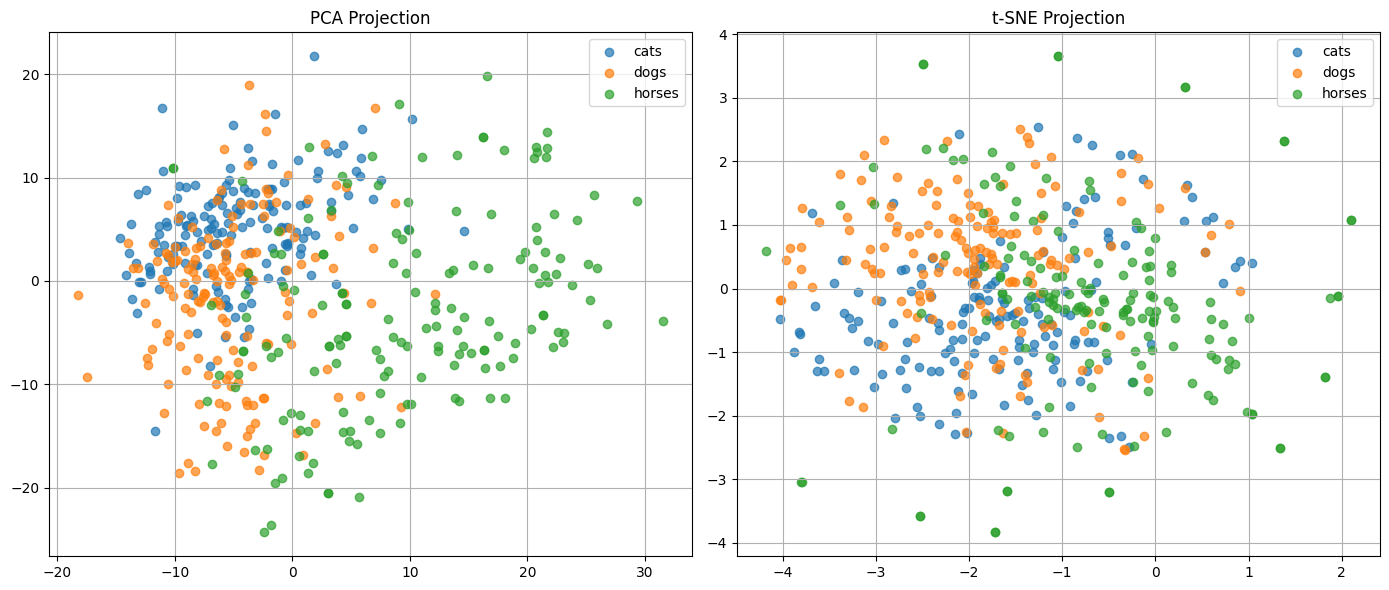

In [103]:
compare_feature_visualizations(mid_features, mid_labels, class_names)

In [109]:
stages = get_resnet_stages("resnet18-f37072fd.pth")
initial_features, initial_labels = extract_features(stages['initial'], train_loader)
print(initial_features.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_24456\131306688.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Using device: cuda
(484, 802816)


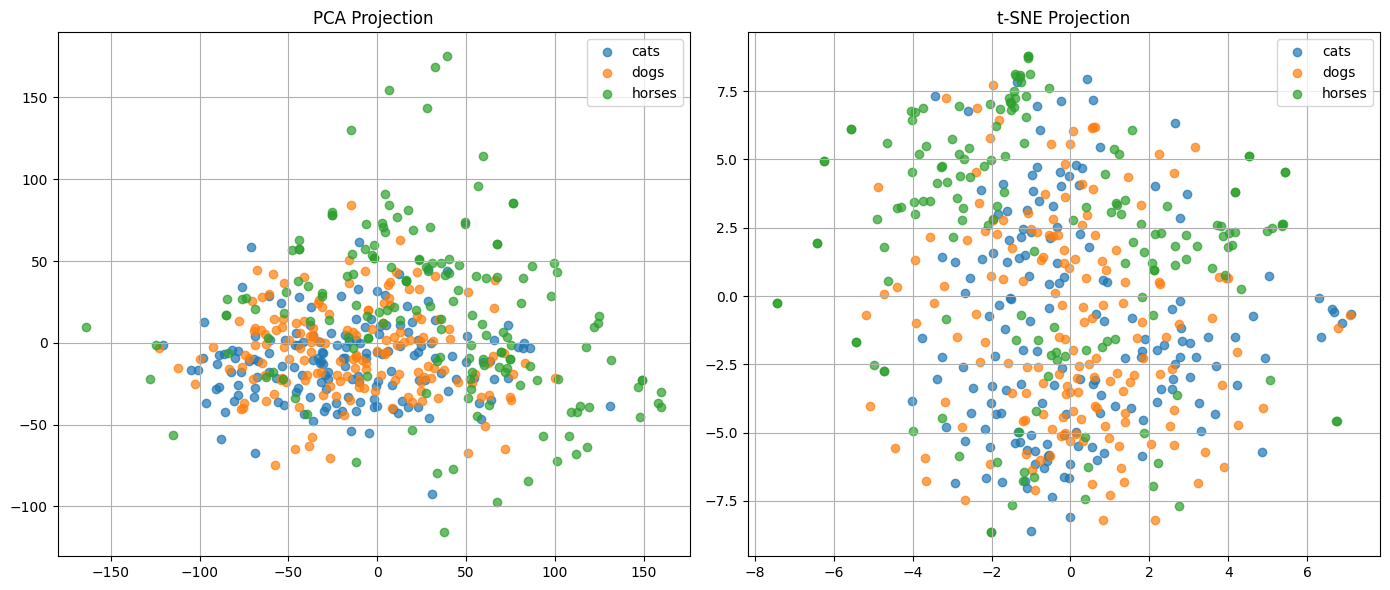

In [111]:
compare_feature_visualizations(initial_features, initial_labels, class_names)

In [141]:
def plot_classifier_metrics(results_df):
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    classifiers = results_df["Classifier"]

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, metric in enumerate(metrics):
        axes[i].bar(classifiers, results_df[metric], color='skyblue')
        axes[i].set_title(metric)
        axes[i].set_ylim(0, 1)
        axes[i].set_ylabel("Score")
        axes[i].set_xticks(range(len(classifiers)))
        axes[i].set_xticklabels(classifiers, rotation=45)
        axes[i].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.suptitle("Classifier Comparison Metrics", fontsize=16, y=1.05)
    plt.show()


In [113]:
def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names):
    classifiers = {
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier()
    }

    results = []

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            "Classifier": name,
            "Accuracy": round(accuracy, 3),
            "Precision": round(report["weighted avg"]["precision"], 3),
            "Recall": round(report["weighted avg"]["recall"], 3),
            "F1-Score": round(report["weighted avg"]["f1-score"], 3)
        })

    df = pd.DataFrame(results)
    return df

In [115]:
X = initial_features
y = initial_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_df = train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names)

results_df

,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,0.608,0.629,0.608,0.608
1,Logistic Regression,0.515,0.507,0.515,0.510
2,Random Forest,0.649,0.657,0.649,0.651
3,KNN,0.557,0.641,0.557,0.499


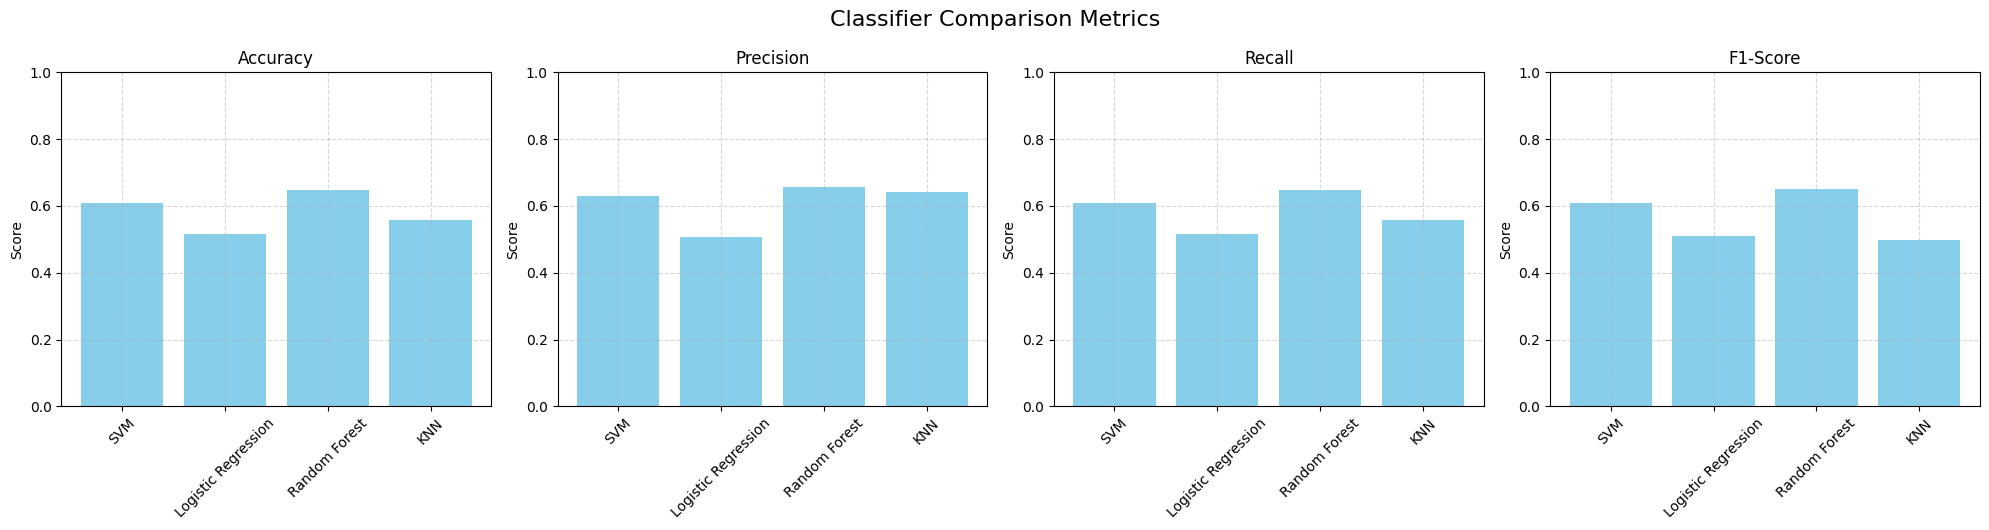

In [143]:
plot_classifier_metrics(results_df)

In [127]:
X = mid_features
y = mid_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_df_mid = train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names)

results_df_mid

,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,0.753,0.776,0.753,0.756
1,Logistic Regression,0.835,0.835,0.835,0.835
2,Random Forest,0.670,0.672,0.670,0.671
3,KNN,0.433,0.307,0.433,0.345


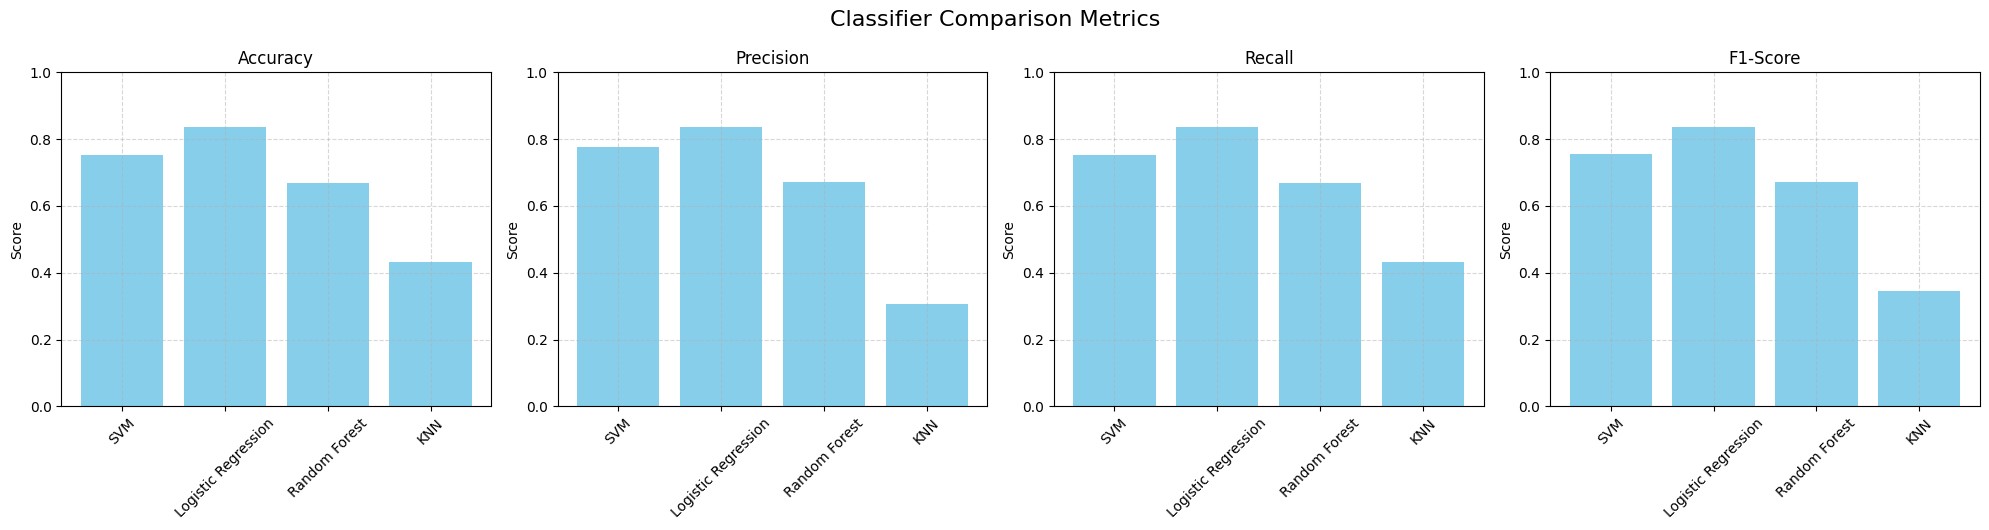

In [145]:
plot_classifier_metrics(results_df_mid)

In [133]:
X = high_features
y = high_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_df_high = train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names)

results_df_high

,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,1.000,1.000,1.000,1.000
1,Logistic Regression,0.990,0.990,0.990,0.990
2,Random Forest,0.969,0.972,0.969,0.969
3,KNN,0.979,0.981,0.979,0.979


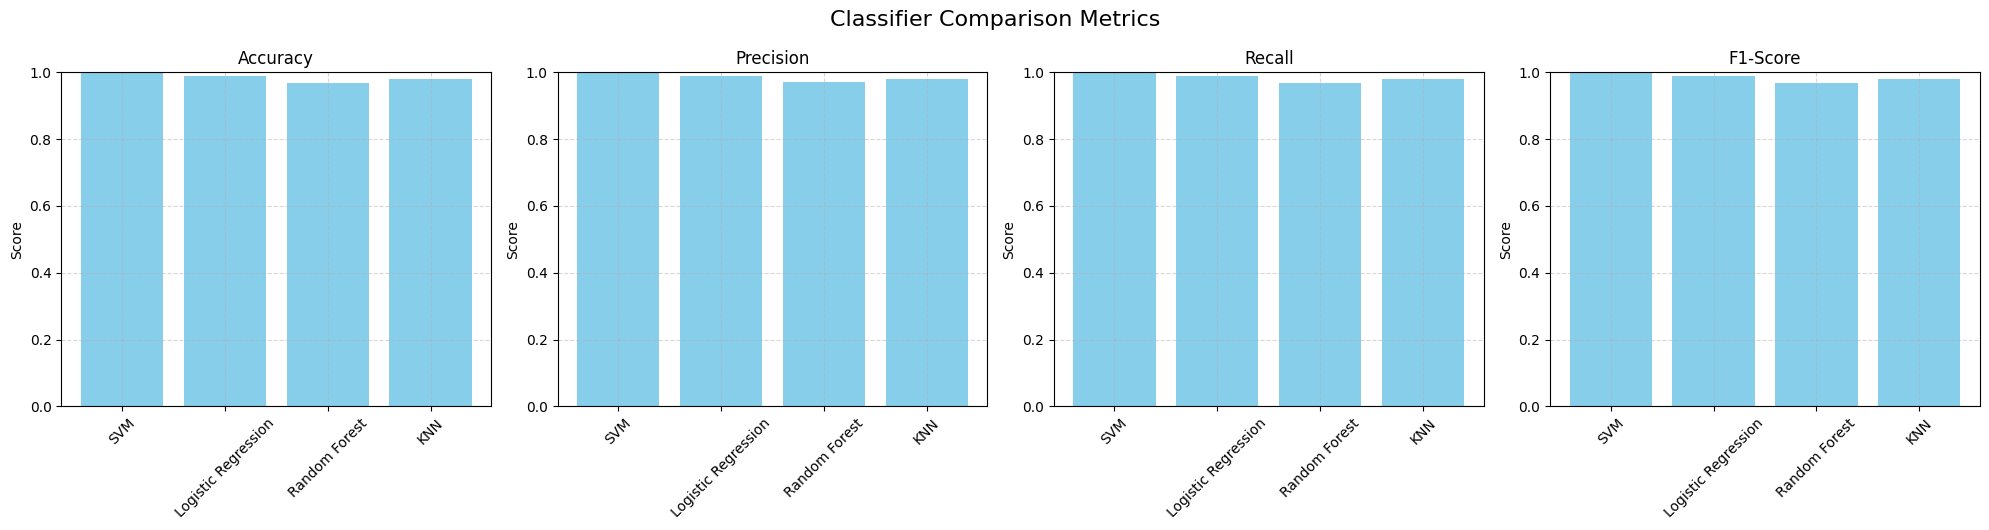

In [147]:
plot_classifier_metrics(results_df_high)